# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

Инструкция по выполнению проекта

 1. Подготовьте данные
 
- 1.1. Откройте файлы и изучите их.
 Путь к файлам:
/datasets/gold_recovery_train.csv.
/datasets/gold_recovery_test.csv.
/datasets/gold_recovery_full.csv.
- 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.
- 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
- 1.4. Проведите предобработку данных.

 2. Проанализируйте данные
 
- 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.
- 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
- 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

 3. Постройте модель
 
- 3.1. Напишите функцию для вычисления итоговой sMAPE.
- 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

Описание данных

Технологический процесс
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, - - Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота
- Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи


Наименование признаков

- Наименование признаков должно быть такое:

[этап].[тип_параметра].[название_параметра]
- Пример: rougher.input.feed_ag
- Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики


Возможные значения для блока [тип_параметра]:

- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

# 1. Подготовка данных

1. Откройте файлы и изучите их

In [1]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from numpy.random import RandomState
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from collections import defaultdict
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
import warnings
warnings.simplefilter('ignore')

In [2]:
# Открываем файлы с данными
gold_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
# Первые 5 строк
display(gold_train.head())
display(gold_test.head())
display(gold_full.head())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
# Информация
display(gold_train.info())
display(gold_test.info())
display(gold_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

None

In [5]:
# Размеры
display(gold_train.shape)
display(gold_test.shape)
display(gold_full.shape)

(16860, 87)

(5856, 53)

(22716, 87)

In [6]:
# Проверим на наличие дубликатов
display(gold_train.duplicated().sum())
display(gold_test.duplicated().sum())
display(gold_full.duplicated().sum())

0

0

0

In [7]:
# Проверим на наличие пропущенных значений
display(sum(gold_train.isna().sum()))
display(sum(gold_test.isna().sum()))
display(sum(gold_full.isna().sum()))

30320

2360

36587

2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

- Recovery = (C*(F-T)) / (F*(C-T)) * 100%

In [8]:
# Функция расчета эффективности обогащения 
def recovery(C, F, T):
    recovery = ((C * (F - T)) / (F * (C - T))) * 100
    recovery[recovery<0] = np.nan # заполнение малых и больших значений
    recovery[recovery>100] = np.nan # заполнение малых и больших значений
    return recovery

In [9]:
# Переменные
C = gold_train['rougher.output.concentrate_au']
F = gold_train['rougher.input.feed_au']
T = gold_train['rougher.output.tail_au']

In [10]:
# Датафрейм с заданными параметрами
recovery_gold = gold_train[['rougher.output.recovery', 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']] 

In [11]:
# Расчет recovery по формуле
recovery_gold['rougher.output.recovery_1'] = recovery(C, F, T)

In [12]:
# МАЕ, пропуски для расчета заменяем на 0
mae = mean_absolute_error(recovery_gold['rougher.output.recovery_1'].fillna(0), recovery_gold['rougher.output.recovery'].fillna(0))
mae

8.00350954615662e-15

Вывод: Эффективность обогащения для признака rougher.output.recovery в обучающей выборке рассчитана правильно, так как значение МАЕ не высокое.

1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [13]:
# Проверим количество столбцов
print(len(gold_train.columns), len(gold_test.columns))

87 53


In [14]:
# Выведем названия отличающихся столбцов
list(set(gold_train.columns) - set(gold_test.columns))

['final.output.concentrate_ag',
 'secondary_cleaner.output.tail_sol',
 'rougher.output.tail_ag',
 'final.output.concentrate_sol',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.concentrate_sol',
 'final.output.concentrate_pb',
 'final.output.tail_ag',
 'secondary_cleaner.output.tail_au',
 'final.output.concentrate_au',
 'final.output.tail_sol',
 'primary_cleaner.output.tail_pb',
 'final.output.recovery',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'rougher.output.tail_pb',
 'secondary_cleaner.output.tail_pb',
 'rougher.output.concentrate_sol',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.output.concentrate_au',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.tail_ag',
 'rougher.calculation.sulfate_to_au_concentrate',
 'primary_cleaner.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.recovery',
 'final.output.tail_pb',
 'rougher.calculation.floatbank11_sulfate_to_

Можно увидеть, что в тестовой выборке не достает признаков, типа 'output', то есть параметры продукта и''calculation'-расчетные харктеристики. В условии сказано, что эти признаки расчитываются гораздо позже. Эти признаки будут не нужны в обучающей выборке, поэтому удалим их.

In [15]:
# Удаление отличающихся(от тестовой) признаков из обучающей выборки
gold_train.drop(list(set(gold_train.columns) - set(gold_test.columns)), axis=1, inplace=True)

В условии сказано, что в тестовой выборке нет целевых признаков. 
Так как в условии сказано, что "модель должна предсказать коэффициент восстановления золота из золотосодержащей руды", нашими целевыми признаками являются 'rougher.output.recovery' и''final.output.recovery'. Добавим их с помощью метода merge. 

In [16]:
# Добавление целевых признаков в обучающую выборку
gold_train = pd.merge(gold_train, gold_full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date')

In [17]:
# Добавление целевых признаков в тестовую выборку
gold_test = pd.merge(gold_test, gold_full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date')

1.4. Проведите предобработку данных.

In [18]:
# Функция для заполнения пропущенных значений
def fill_nan(data):
    data = data.fillna(method = 'ffill')
    return data

In [19]:
# Заменяем пропуски
gold_train = fill_nan(gold_train)
gold_test = fill_nan(gold_test)
gold_full = fill_nan(gold_full)

In [20]:
# Проверим на наличие пропущенных значений
display(sum(gold_train.isna().sum()))
display(sum(gold_test.isna().sum()))
display(sum(gold_full.isna().sum()))

0

0

0

In [21]:
# У столбца 'date' поменяем тип данных с object на datetime
gold_train['date'] = pd.to_datetime(gold_train['date'])
gold_test['date'] = pd.to_datetime(gold_test['date'])
gold_full['date'] = pd.to_datetime(gold_full['date'])

- Исходные данные: 3 таблицы с данными(полная, обучающая и тестовые выборки);
- В выборках имеются пропущенные значения, которые впоследствии были заполнены с помощью метода 'ffill', так как в технических процессах значения близки с соседними значениями;
- В столбце 'date' тип данных был изменен с 'object' на datetime;
- Эффективность обогащения для признака rougher.output.recovery в обучающей выборке рассчитана правильно, так как значение МАЕ не высокое;
- В тестовой выборке не достает признаков, типа 'output', то есть параметры продукта и''calculation'-расчетные харктеристики;
- Удалили эти признаки из обучающей выборки;
- Так как в условии сказано, что "модель должна предсказать коэффициент восстановления золота из золотосодержащей руды", нашими целевыми признаками являются 'rougher.output.recovery' и''final.output.recovery';
- Добавили целевые признаки в обучающую и тестовую выборки

# 2. Анализ данных

2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

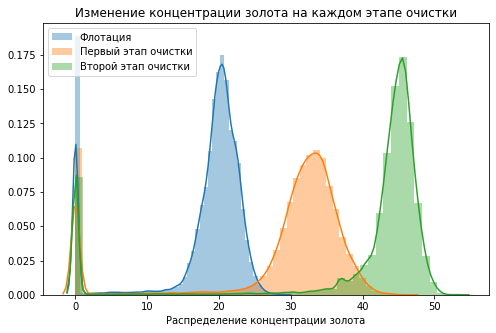

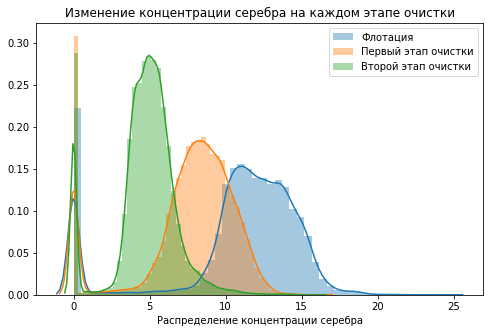

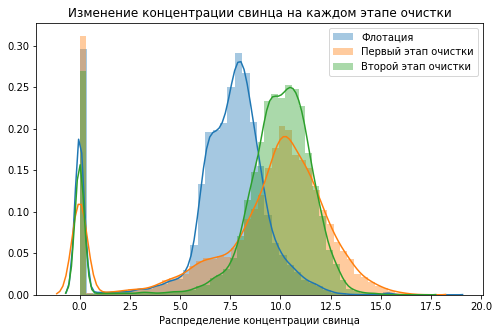

In [22]:
# Построим графики концентрации золота(Au), серебра(Ag) и свинца(Pb) после различных этапов очистки
metals = [('au', 'золота'), ('ag', 'серебра'), ('pb', 'свинца')]

stages = [('rougher.output.concentrate_', 'Флотация'), 
               ('primary_cleaner.output.concentrate_', 'Первый этап очистки'), 
               ('final.output.concentrate_', 'Второй этап очистки')]


for i in metals:
    plt.figure(figsize=(8,5))
    for item in stages:
        ax = sns.distplot(gold_full[item[0] + i[0]], label=item[1])
        plt.legend()
        _ = ax.set(xlabel='Распределение концeнтрации ' + i[1], 
                   title='Изменение концентрации ' + i[1] + ' на каждом этапе очистки')
    plt.show()

Из первого графика мы видим, что концентрация золота вырастает после третьего этапа очисти. А содержание серебра, как можно видеть на втором графике, уменьшается с каждым этапом очистки и после третьего этапа концентрация его минимальна. Концентрация свинца уменьшается после первого этапа очисти и растет после второго этапа очистки, но доля его меньше, чем после флотации. 

2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

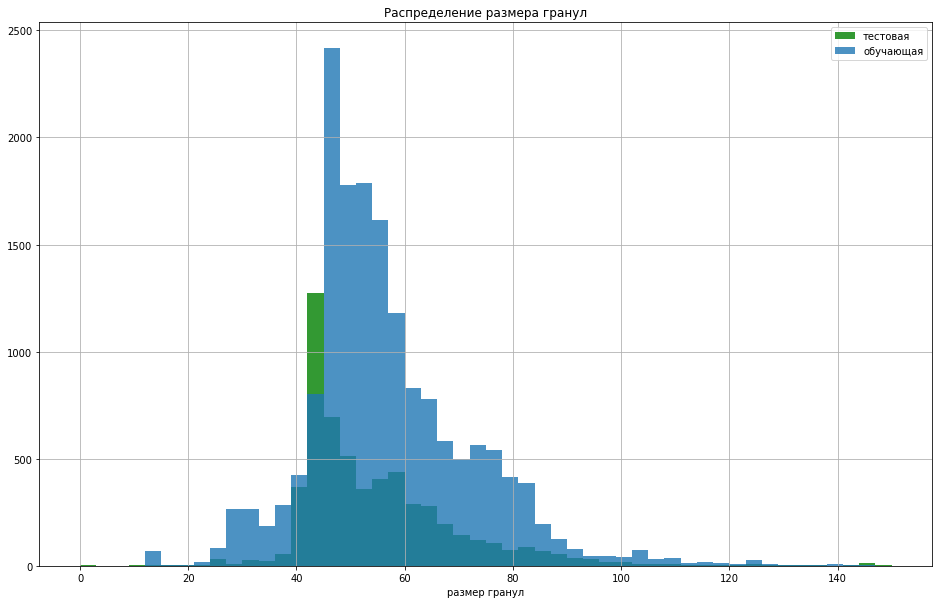

In [23]:
# Построим график распределения размеров гранул на тестовой и на обучающей выборках
figure(num=None, figsize=(16, 10))
gold_test['rougher.input.feed_size'].hist(alpha=0.8, bins=50, range=(0,150), color='g')
gold_train['rougher.input.feed_size'].hist(alpha=0.8, bins=50, range=(0,150))
plt.title('Распределение размера гранул')
plt.xlabel('размер гранул')
plt.legend(['тестовая', 'обучающая'])
plt.grid(True)
plt.show()

In [24]:
# Посчитаем медиану
print(gold_train['rougher.input.feed_size'].median())
print(gold_test['rougher.input.feed_size'].median())

54.066002564546224
49.96479572039952


In [25]:
# Посчитаем среднее
print(gold_train['rougher.input.feed_size'].mean())
print(gold_test['rougher.input.feed_size'].mean())

60.18859533601633
55.89886568885065


Распределение размеров гранул сырья на тестовой и на обучающей выборках визуально схожи, медиана и среднее различаются на тестовой и обучающей выборках на 5 единиц.

2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

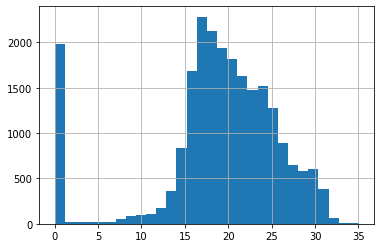

In [26]:
# График суммарная концентрация металлов в сырье
gold_full['input_sum'] = gold_full[['rougher.input.feed_ag','rougher.input.feed_pb', 
    'rougher.input.feed_au']].sum(axis=1)
gold_full['input_sum'].hist(bins=30)

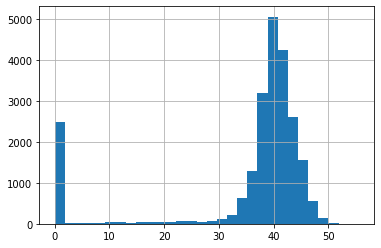

In [27]:
# График суммарная концентрация металлов в черновом концентрате
gold_full['rougher.output_sum'] = gold_full[['rougher.output.concentrate_ag','rougher.output.concentrate_pb', 'rougher.output.concentrate_au']].sum(axis=1)
gold_full['rougher.output_sum'].hist(bins=30)

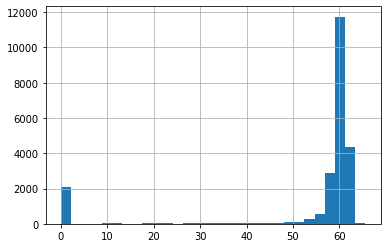

In [28]:
# График суммарная концентрация металлов в финальном концентрате
gold_full['final.output_sum'] = gold_full[['final.output.concentrate_ag','final.output.concentrate_pb', 'final.output.concentrate_au']].sum(axis=1)
gold_full['final.output_sum'].hist(bins=30)

На всех трех графиках видно, что имеются выбросы в районе 0. Посмотрим на ящик с усами.

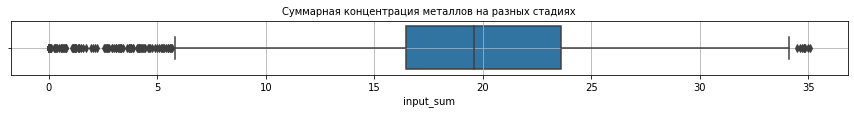

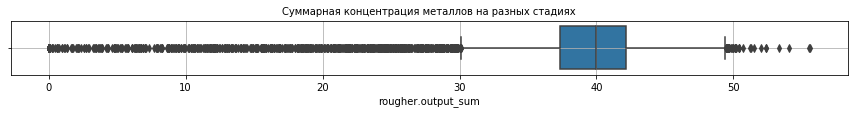

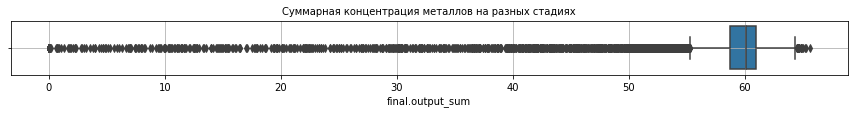

In [29]:
# Построение boxplot
gold_key = gold_full[['input_sum', 'rougher.output_sum', 'final.output_sum']]
for i in gold_key:
    plt.figure(figsize=(15,1))
    sns.boxplot(gold_key[i], orient='h')
    plt.title('Суммарная концентрация металлов на разных стадиях', fontsize=10)
    plt.grid(True)
    plt.show()

Из обеих видов графиков можно сделать такой вывод: для концентрации металлов в сырье выбросами можно считать значения меньше 7 и более 34, в черновом концентрате выбросами можно считать значения меньше 30 и более 49, а в финальном - значения меньше 55. Произведем очистку от выбросов.

In [30]:
# Функция для удаления выбросов, 
# создает список столбцов ввиде ключей, находит межквартильный размах,
# удаляет выбросы, на выходе-таблица без выбросов
def outlier(df, columns):
    fence_map = defaultdict(list)
    for name in columns:
        q1 = df[name].quantile(0.25)
        q3 = df[name].quantile(0.75)
        iqr = q3-q1 
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        fence_map[name] = (fence_low, fence_high)
    df_out = df
    for k, v in fence_map.items():
        df_out = df_out.loc[(df_out[k] > v[0]) & (df_out[k] < v[1])]
    return df_out
columns = ['input_sum', 'rougher.output_sum', 'final.output_sum']
print(gold_full.shape)
full = outlier(gold_full, columns)
print(full.shape)

(22716, 90)
(18563, 90)


Построим гистограммы и убедимся, что очистка от выбросов состоялась

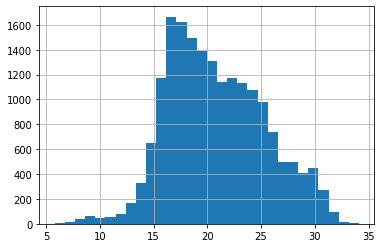

In [31]:
### График суммарная концентрация металлов в сырье
full['input_sum'].hist(bins=30)

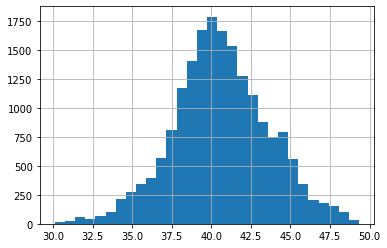

In [32]:
### График суммарная концентрация металлов в черновом концентрате
full['rougher.output_sum'].hist(bins=30)

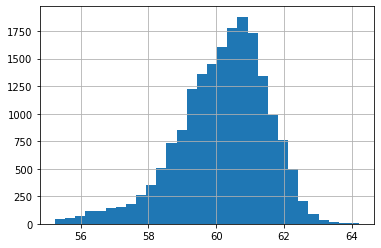

In [33]:
# График суммарная концентрация металлов в финальном концентрате
full['final.output_sum'].hist(bins=30)

Эти графики выглядят уже привлекательнее. Так же удалим нулевые значения суммарной концентрации металлов в сырье. В сырье не может быть нулевых содержаний металлов.

In [34]:
# Добавим столбец с суммарным содержанием металлов в сырье в обучающую и тестовую выборки
train = gold_train.merge(full[['date','input_sum']], how='left', on='date')
test = gold_test.merge(full[['date','input_sum']], how='left', on='date')
print('До(обучающая):',train.shape[0])
print('До(тестовая):',test.shape[0])

До(обучающая): 16860
До(тестовая): 5856


In [35]:
# Удаляем нулевые значения сумм металлов в сырье из обучающей выборки 
train = train[train.input_sum.notnull()]
train = train.drop(['input_sum'], axis=1)
print('После(обучающая):',train.shape[0])

После(обучающая): 13606


In [36]:
# Удаляем нулевые значения сумм металлов в сырье из тестовой выборки 
test = test[test.input_sum.notnull()]
test = test.drop(['input_sum'], axis=1)
print('После(тестовая):',test.shape[0])

После(тестовая): 4957


- Из графиков мы видим, что концентрация золота вырастает после третьего этапа очистки. А содержание серебра уменьшается с каждым этапом очистки и после третьего этапа концентрация его минимальна. Концентрация свинца уменьшается после первого этапа очисти и растет после второго этапа очистки, но доля его меньше, чем после флотации. 
- Распределение размеров гранул сырья на тестовой и на обучающей выборках визуально схожи, медиана и среднее различаются на тестовой и обучающей выборках на 5 единиц.
- Исходя из графиков можно сделать такой вывод: для концентрации металлов в сырье выбросами можно считать значения меньше 7 и более 34, в черновом концентрате выбросами можно считать значения меньше 30 и более 49, а в финальном - значения меньше 55. Произведем очистку от выбросов.
- Применили функцию для очистки выбросов для полной выборки и удалили нулевые значения сумм металлов в сырье для обучающей и тестовой выборок.

# 3. Модель

3.1. Напишите функцию для вычисления итоговой sMAPE.

In [37]:
# Исходя из формулы, полученной в описании к проекту, функция итоговой sMAPE: 
def final_smape(target, prediction):
    
    def smape(target, prediction):
        smape = np.mean((np.abs(target - prediction)/((np.abs(target)+np.abs(prediction))/2))) * 100
        return smape
    
    smape_r = smape(target[:,0], prediction[:,0])
    smape_f = smape(target[:,1], prediction[:,1])
    final_smape = .25*smape_r + .75*smape_f
    return final_smape

In [38]:
# Для использования функции в дальнейшем, используем make_scorer
smape_scorer = make_scorer(final_smape)

3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

In [39]:
# Обозначим целевые признаки и признаки в обучающей и тестовой выборках
target_train = train[['rougher.output.recovery', 'final.output.recovery']]
features_train = train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
features_train = features_train.set_index('date')
target_test = test[['rougher.output.recovery', 'final.output.recovery']]
features_test = test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
features_test = features_test.set_index('date')

In [40]:
# LinearRegression 
model_lr = LinearRegression()
train_smape_lr = cross_validate(model_lr,features_train,target_train.to_numpy(), scoring=smape_scorer, cv=5)

for k, v in train_smape_lr.items():
    print(k,v)
    
final_score = train_smape_lr['test_score']
print('среднее smape: ', np.sum(final_score)/5)

fit_time [0.30229044 0.50729036 0.40489531 0.30411792 0.49512148]
score_time [0.09139824 0.09465384 0.09089446 0.00276351 0.20127058]
test_score [12.48142124  8.95938551  8.14864254  8.2979985  13.63654904]
среднее smape:  10.304799366459886


In [41]:
# DecisionTreeRegressor
for depth in range(1,10):
    model_dt = DecisionTreeRegressor(random_state=2021, max_depth=depth)

    train_smape_dt = cross_validate(model_dt,features_train,target_train.to_numpy(), scoring=smape_scorer, cv=5)

    for k, v in train_smape_dt.items():
        print(k,v)

    final_score = train_smape_dt['test_score']
    print("среднее smape с глубиной {}: {}".format(depth, np.sum(final_score)/5))

fit_time [0.50637007 0.50568676 0.39279127 0.50134015 0.48513746]
score_time [0.00163317 0.0013752  0.00137448 0.00136781 0.00161242]
test_score [ 9.59238885  7.34971795  7.95900806  8.71664947 11.29526633]
среднее smape с глубиной 1: 8.982606131160182
fit_time [1.01325965 0.97731566 0.8136456  1.08307028 0.91273832]
score_time [0.00131178 0.00161505 0.00135183 0.00169015 0.00171661]
test_score [10.05685515  7.66362346  8.27192673  8.7022669  11.3170903 ]
среднее smape с глубиной 2: 9.202352507116865
fit_time [1.298316   1.21332908 1.30803776 1.20222235 1.20750999]
score_time [0.08127475 0.00140238 0.0092485  0.08154202 0.00167918]
test_score [ 9.65712666  7.63292015  9.32354216  8.65269394 12.47238399]
среднее smape с глубиной 3: 9.54773338147444
fit_time [1.70991135 1.78537726 1.61070895 1.58581591 1.50342846]
score_time [0.00145268 0.00178313 0.00158453 0.00157261 0.00834465]
test_score [ 9.94086139  7.95579636 10.37928613  8.27136397 11.79837976]
среднее smape с глубиной 4: 9.66913

Наименьшее значение sampe = 8.98 при глубине дерева =1.

In [42]:
# RandomForest
model_rf = RandomForestRegressor(n_estimators=10, random_state=2021)
train_smape_lr = cross_validate(model_rf,features_train,target_train.to_numpy(), scoring=smape_scorer, cv=5)

for k, v in train_smape_lr.items():
    print(k,v)
    
final_score = train_smape_lr['test_score']
print('среднее smape: ', np.sum(final_score)/5)


fit_time [38.20478392 39.99450898 35.89418888 35.60014176 37.09748173]
score_time [0.09448361 0.00639987 0.00620484 0.00568151 0.09099627]
test_score [10.80925372  8.72834773  9.11986409  9.62497628 12.37072166]
среднее smape:  10.130632697112077


Наименьшее значение sampe = 8.98 нам показала модель решающего дерева в регрессии. С этой моделью и будем работать дальше

In [43]:
# Обучение наилучшей модели и проверка на тестовой выборке
model_dtr = DecisionTreeRegressor(random_state=2021, max_depth=1)
model_dtr.fit(features_train, target_train)
prediction = model_dtr.predict(features_test)
smape = final_smape(target_test.to_numpy(), prediction)
print('финальное значение smape:', smape)

финальное значение smape: 6.781892166636322


Вывод:

 Этап1:
  
- Исходные данные: 3 таблицы с данными(полная, обучающая и тестовые выборки);
- В выборках имеются пропущенные значения, которые впоследствии были заполнены с помощью метода 'ffill', так как в технических процессах значения близки с соседними значениями;
- В столбце 'date' тип данных был изменен с 'object' на datetime;
- Эффективность обогащения для признака rougher.output.recovery в обучающей выборке рассчитана правильно, так как значение МАЕ не высокое;
- В тестовой выборке не достает признаков, типа 'output', то есть параметры продукта и''calculation'-расчетные харктеристики;
- Удалили эти признаки из обучающей выборки;
- Так как в условии сказано, что "модель должна предсказать коэффициент восстановления золота из золотосодержащей руды", нашими целевыми признаками являются 'rougher.output.recovery' и''final.output.recovery';
- Добавили целевые признаки в обучающую и тестовую выборки

 Этап2:
  
- Из графиков видно, что концентрация золота вырастает после третьего этапа очистки. А содержание серебра уменьшается с каждым этапом очистки и после третьего этапа концентрация его минимальна. Концентрация свинца уменьшается после первого этапа очисти и растет после второго этапа очистки, но доля его меньше, чем после флотации. 
- Распределение размеров гранул сырья на тестовой и на обучающей выборках визуально схожи, медиана и среднее различаются на тестовой и обучающей выборках на 5 единиц.
- Исходя из графиков можно сделать такой вывод: для концентрации металлов в сырье выбросами можно считать значения меньше 7 и более 34, в черновом концентрате выбросами можно считать значения меньше 30 и более 49, а в финальном - значения меньше 55. Произведем очистку от выбросов.
- Применили функцию для очистки выбросов для полной выборки и удалили нулевые значения сумм металлов в сырье для обучающей и тестовой выборок.

 Этап3:
 
- Лучшее значение smape показала модель решающего дерева с глубиной 1. Финальное значение smape на тестовой выборке =  6.78.